# Data Counts per Task

/home/jovyan/miniconda3/envs/MolDA_CHJ/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading datasets and counting tasks...
[Train] Loaded 2850760 examples.
[Val] Loaded 70906 examples.
[Test] Loaded 70906 examples.

 [ Data Source Count Summary ] 
                     Task Source  Train  Val  Test  Total
          smol-forward_synthesis 971809 6111  6111 984031
             smol-retrosynthesis 941735 6248  6248 954231
                  retrosynthesis 126110 3574  3574 133258
              reagent_prediction 121896 3488  3488 128872
     forward_reaction_prediction 121896 3488  3488 128872
                        qm9_homo 117660 3086  3086 123832
                        qm9_lumo 117708 3045  3045 123798
               qm9_homo_lumo_gap 117541 3060  3060 123661
        smol-molecule_captioning  56498 3807  3807  64112
        smol-molecule_generation  56498 3762  3762  64022
    smol-property_prediction-hiv  32864 8211  8211  49286
  smol-property_prediction-sider  22820 5720  5720  34260
               chebi-20-text2mol  18777 7630  7630  34037
               chebi-20-

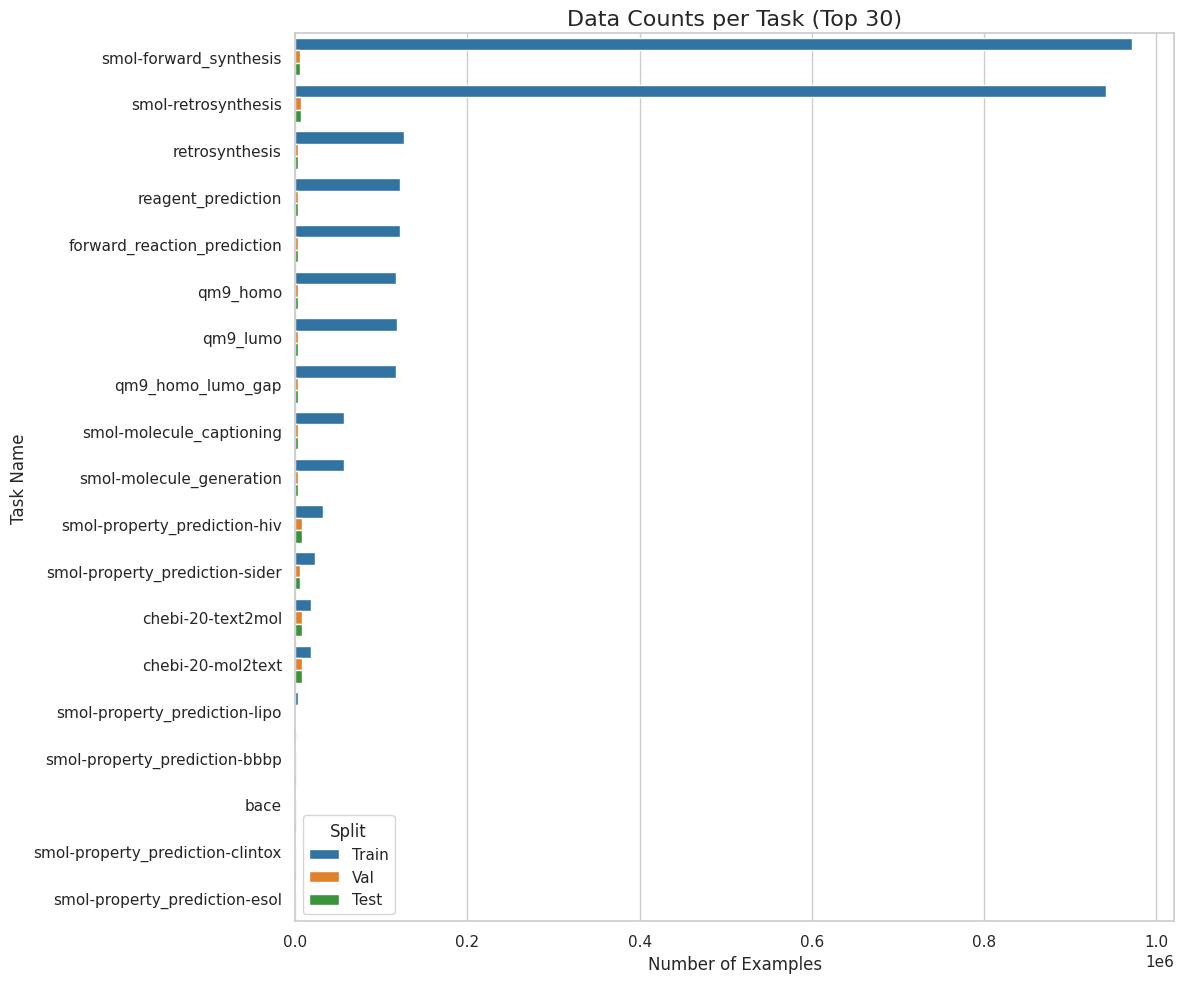

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_from_disk
import numpy as np

# =============================================================================
# [설정] 데이터셋 경로
# =============================================================================
BASE_DIR = "/home/jovyan/CHJ/Mol-LLM_Custom/dataset/llada_train"
TRAIN_PATH = os.path.join(BASE_DIR, "GSAI-ML-LLaDA-8B-Instruct_string+graph_q32_train_3.3M_0415")
VAL_PATH = os.path.join(BASE_DIR, "GSAI-ML-LLaDA-8B-Instruct_string+graph_q32_validation_3.3M_0415")
TEST_PATH = os.path.join(BASE_DIR, "GSAI-ML-LLaDA-8B-Instruct_string+graph_q32_test_3.3M_0415")

def main():
    paths = {
        "Train": TRAIN_PATH,
        "Val": VAL_PATH,
        "Test": TEST_PATH
    }

    # 결과를 저장할 딕셔너리
    counts_data = {}

    print("Loading datasets and counting tasks...")
    
    # 1. 각 Split 별로 데이터셋 로드 및 Task 카운팅
    for split, path in paths.items():
        if not os.path.exists(path):
            print(f"[Warning] Path not found: {path}")
            continue
            
        try:
            # 데이터셋 로드 (메모리 효율을 위해 필요한 컬럼만 로드하는 것이 좋으나, 
            # load_from_disk는 Lazy Loading이므로 일단 로드 후 특정 컬럼만 접근)
            ds = load_from_disk(path)
            print(f"[{split}] Loaded {len(ds)} examples.")
            
            # 'task' 컬럼이 데이터 소스를 구분하는 키라고 가정합니다.
            # (이전 코드에서 prepare_data_instance 함수가 'task' 필드를 생성함)
            if 'task' in ds.column_names:
                # Pandas로 변환하여 빠르게 카운팅
                # 전체 데이터를 Pandas로 바꾸면 무거울 수 있으므로 'task' 컬럼만 추출
                task_col = ds.select_columns(['task']).to_pandas()['task']
                counts = task_col.value_counts().to_dict()
                counts_data[split] = counts
            else:
                print(f"[{split}] 'task' column not found. Available columns: {ds.column_names}")
                
        except Exception as e:
            print(f"[{split}] Error processing: {e}")

    # 2. 데이터프레임으로 통합 (Pivot Table 형태)
    # Row: Task Name, Column: Train, Val, Test
    df = pd.DataFrame(counts_data).fillna(0).astype(int)
    
    # 총계 컬럼 추가
    df['Total'] = df.sum(axis=1)
    
    # 총계 기준 내림차순 정렬
    df = df.sort_values(by='Total', ascending=False)
    
    # 인덱스(Task 이름)를 컬럼으로 빼냄
    df.reset_index(inplace=True)
    df.rename(columns={'index': 'Task Source'}, inplace=True)

    # 3. 결과 테이블 출력
    print("\n" + "="*80)
    print(" [ Data Source Count Summary ] ")
    print("="*80)
    # 보기 좋게 출력
    print(df.to_string(index=False))
    print("-" * 80)
    print(f"Grand Total: {df['Total'].sum()}")
    print("="*80)

    # CSV로 저장 (나중에 엑셀 등에서 보려면)
    # csv_filename = "data_source_counts.csv"
    # df.to_csv(csv_filename, index=False)
    # print(f"\nTable saved to: {csv_filename}")

    # 4. 시각화 (Top 20 Tasks)
    # Task가 너무 많으면 그래프가 복잡해지므로 상위 20개만 시각화하거나, 전체를 길게 그립니다.
    top_n = 30
    plot_df = df.head(top_n).copy()
    
    # 시각화를 위해 Melt (Long format 변환)
    plot_df_melted = plot_df.melt(id_vars=['Task Source', 'Total'], 
                                  value_vars=['Train', 'Val', 'Test'], 
                                  var_name='Split', value_name='Count')

    plt.figure(figsize=(12, 10))
    sns.set_theme(style="whitegrid")
    
    # Stacked Bar Chart 느낌을 주기 위해 Total 먼저 그리고, 그 위에 Split별로 그리는 방식 대신
    # 여기서는 보기 편하게 Horizontal Bar Chart로 그립니다.
    
    # 정렬 순서 유지
    order = plot_df['Task Source'].tolist()
    
    ax = sns.barplot(data=plot_df_melted, x='Count', y='Task Source', hue='Split', 
                     order=order, palette={'Train': '#1f77b4', 'Val': '#ff7f0e', 'Test': '#2ca02c'})
    
    plt.title(f"Data Counts per Task (Top {top_n})", fontsize=16)
    plt.xlabel("Number of Examples", fontsize=12)
    plt.ylabel("Task Name", fontsize=12)
    plt.legend(title="Split")
    
    # 수치 텍스트 표시 (Total 값)
    for i, p in enumerate(ax.containers[0]): # Train bar 기준으로 위치 잡기 (약식)
        # Total 값을 해당 Task의 끝에 표시하고 싶지만, hue가 있어서 복잡함.
        # 대신 Y축 레이블 옆에 Total 값을 괄호로 병기하는 방식 등으로 처리 가능하나 생략.
        pass

    plt.tight_layout()
    # img_filename = "data_source_distribution.png"
    #  plt.savefig(img_filename, dpi=300)
    # print(f"Graph saved to: {img_filename}")

if __name__ == "__main__":
    main()

# Task Count Per Task Group

Loading datasets and grouping tasks...
[Train] Loaded 2850760 examples.
[Val] Loaded 70906 examples.
[Test] Loaded 70906 examples.

 [ Dataset Statistics by Group ] 
                                 Group   Train   Val  Test   Total
           Forward Reaction Prediction 1093705  9599  9599 1112903
                        Retrosynthesis 1067845  9822  9822 1087489
      Property Prediction (Regression)  357157 10254 10254  377665
                    Reagent Prediction  121896  3488  3488  128872
                   Molecule Captioning   75275 11437 11437   98149
Description-Guided Molecule Generation   75275 11392 11392   98059
  Property Prediction (Classification)   59607 14914 14914   89435
------------------------------------------------------------------------------------------
Grand Total: 2992572

Generating visualization...


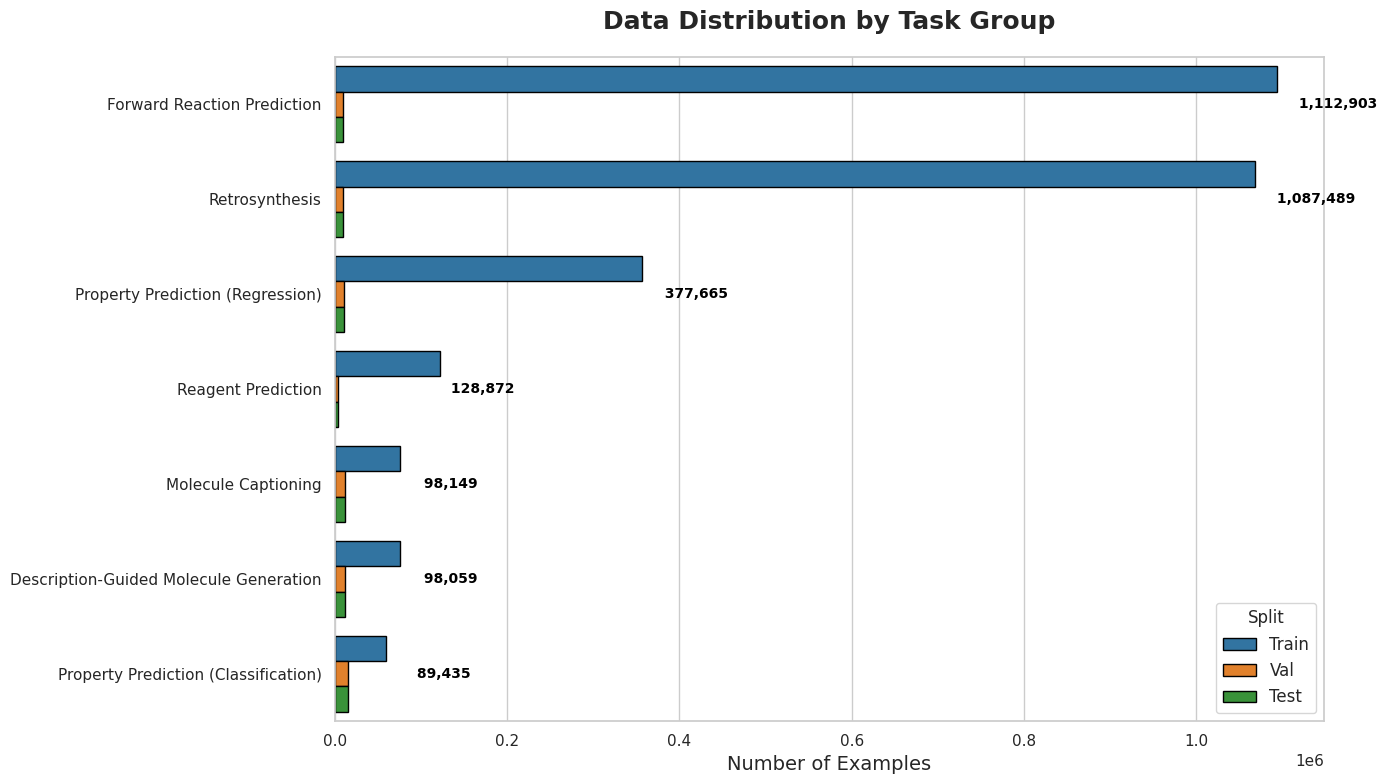

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_from_disk
import numpy as np

# =============================================================================
# [설정] 데이터셋 경로
# =============================================================================
BASE_DIR = "/home/jovyan/CHJ/Mol-LLM_Custom/dataset/llada_train"
TRAIN_PATH = os.path.join(BASE_DIR, "GSAI-ML-LLaDA-8B-Instruct_string+graph_q32_train_3.3M_0415")
VAL_PATH = os.path.join(BASE_DIR, "GSAI-ML-LLaDA-8B-Instruct_string+graph_q32_validation_3.3M_0415")
TEST_PATH = os.path.join(BASE_DIR, "GSAI-ML-LLaDA-8B-Instruct_string+graph_q32_test_3.3M_0415")

# =============================================================================
# [핵심] Task -> Group 매핑 로직
# =============================================================================
def get_task_group(task_name):
    # 안전장치: 문자열이 아닌 경우 처리
    if not isinstance(task_name, str):
        return "Others"
        
    t = task_name.lower()

    # 1. Name Conversion
    if "name_conversion" in t:
        return "Name Conversion"

    # 2. Molecule Captioning
    if "captioning" in t or "mol2text" in t:
        return "Molecule Captioning"

    # 3. Description-Guided Molecule Generation
    if "generation" in t or "text2mol" in t:
        return "Description-Guided Molecule Generation"

    # 4. Reaction Prediction Tasks
    if "forward_reaction" in t or "forward_synthesis" in t:
        return "Forward Reaction Prediction"
    if "retrosynthesis" in t:
        return "Retrosynthesis"
    if "reagent" in t:
        return "Reagent Prediction"

    # 5. Property Prediction (Classification vs Regression)
    # 일반적인 벤치마크 이름으로 구분
    classification_keywords = [
        "tox21", "toxcast", "clintox", "bbbp", "bace", "sider", 
        "hiv", "muv", "pcba", "multi_label_classification"
    ]
    regression_keywords = [
        "esol", "freesolv", "lipo", "qm7", "qm8", "qm9", 
        "u0", "cv", "mu", "alpha", "r2", "zpve", "gap", "homo", "lumo",
        "hopv"
    ]

    for kw in classification_keywords:
        if kw in t:
            return "Property Prediction (Classification)"
    
    for kw in regression_keywords:
        if kw in t:
            return "Property Prediction (Regression)"

    # 예외 처리
    if "classification" in t:
        return "Property Prediction (Classification)"
    if "regression" in t or "property" in t:
        return "Property Prediction (Regression)"

    return "Others"

def main():
    paths = {
        "Train": TRAIN_PATH,
        "Val": VAL_PATH,
        "Test": TEST_PATH
    }

    raw_data_list = []

    print("Loading datasets and grouping tasks...")
    
    for split, path in paths.items():
        if not os.path.exists(path):
            print(f"[Warning] Path not found: {path}")
            continue
            
        try:
            ds = load_from_disk(path)
            print(f"[{split}] Loaded {len(ds)} examples.")
            
            if 'task' in ds.column_names:
                # Task 컬럼 추출 (Series 형태)
                tasks = ds.select_columns(['task']).to_pandas()['task']
                
                # [수정된 부분] 딕셔너리를 사용하여 DataFrame 생성 (데이터 매칭 문제 해결)
                temp_df = pd.DataFrame({'Task Name': tasks})
                temp_df['Split'] = split
                
                # 그룹 매핑 적용
                temp_df['Group'] = temp_df['Task Name'].apply(get_task_group)
                
                raw_data_list.append(temp_df)
            else:
                print(f"[{split}] 'task' column missing.")

        except Exception as e:
            print(f"[{split}] Error: {e}")
            import traceback
            traceback.print_exc()

    if not raw_data_list:
        print("No data loaded. Exiting.")
        return

    # 통합 DataFrame 생성
    full_df = pd.concat(raw_data_list, ignore_index=True)

    # 데이터가 비어있는지 확인
    if full_df.empty:
        print("Error: The concatenated DataFrame is empty. Check data loading.")
        return

    # =============================================================================
    # 1. 그룹별 통계 집계 (Pivot Table)
    # =============================================================================
    # Group, Split 별 개수 세기
    grouped_df = full_df.groupby(['Group', 'Split']).size().unstack(fill_value=0)
    
    # 컬럼 순서 정렬 (Train -> Val -> Test)
    cols = [c for c in ['Train', 'Val', 'Test'] if c in grouped_df.columns]
    grouped_df = grouped_df[cols]

    # Total 컬럼 추가
    grouped_df['Total'] = grouped_df.sum(axis=1)
    
    # Total 기준 내림차순 정렬
    grouped_df = grouped_df.sort_values(by='Total', ascending=False)
    
    # 인덱스 리셋
    grouped_df.reset_index(inplace=True)

    # 출력
    print("\n" + "="*90)
    print(" [ Dataset Statistics by Group ] ")
    print("="*90)
    print(grouped_df.to_string(index=False))
    print("-" * 90)
    print(f"Grand Total: {grouped_df['Total'].sum()}")
    print("="*90)

    # CSV 저장
    # grouped_df.to_csv("dataset_group_statistics.csv", index=False)
    # print("Saved table to: dataset_group_statistics.csv")

    # =============================================================================
    # 2. 시각화 (Grouped Bar Chart)
    # =============================================================================
    print("\nGenerating visualization...")
    
    # 시각화를 위해 Long Format 변환
    plot_df = grouped_df.melt(id_vars=['Group', 'Total'], 
                              value_vars=cols, 
                              var_name='Split', value_name='Count')
    
    plt.figure(figsize=(14, 8))
    sns.set_theme(style="whitegrid")
    
    # 색상 팔레트 설정
    colors = {'Train': '#1f77b4', 'Val': '#ff7f0e', 'Test': '#2ca02c'}
    
    # 바 차트 그리기
    ax = sns.barplot(
        data=plot_df, 
        y='Group', 
        x='Count', 
        hue='Split', 
        palette=colors,
        edgecolor='black'
    )

    # 제목 및 라벨 설정
    plt.title("Data Distribution by Task Group", fontsize=18, fontweight='bold', pad=20)
    plt.xlabel("Number of Examples", fontsize=14)
    plt.ylabel("", fontsize=14)
    plt.legend(title="Split", fontsize=12, title_fontsize=12)
    
    # 각 그룹 옆에 Total 개수 텍스트로 표시
    for i, total_val in enumerate(grouped_df['Total']):
        # 막대 끝부분에 글자를 적기 위해 x 좌표 계산 (로그 스케일이 아니므로 단순 값 사용)
        ax.text(total_val, i, f" {int(total_val):,}", 
                va='center', ha='left', fontsize=10, fontweight='bold', color='black')

    plt.tight_layout()
    
    # 이미지 저장
    # save_img = "dataset_group_distribution.png"
    # plt.savefig(save_img, dpi=300)
    # print(f"Visualization saved to: {os.path.abspath(save_img)}")

if __name__ == "__main__":
    main()

In [3]:
from datasets import load_from_disk
TRAIN_PATH = os.path.join(BASE_DIR, "GSAI-ML-LLaDA-8B-Instruct_string+graph_q32_train_3.3M_0415")

train_ds = load_from_disk(TRAIN_PATH)

# Token 갯수 distribution visualization

/home/jovyan/miniconda3/envs/MolDA_CHJ/lib/python3.10/site-packages/torch/cuda/__init__.py:61: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


Loading tokenizer: GSAI-ML/LLaDA-8B-Instruct
Loading datasets...
Loaded: ['train', 'val', 'test']

Processing train dataset (2850760 examples)...


Tokenizing train (num_proc=32): 100%|██████████| 2850760/2850760 [00:51<00:00, 55550.33 examples/s]


--- TRAIN Statistics ---
Count: 2850760.00
Mean: 314.45
Median: 302.00
Min: 88.00
Max: 3053.00
Std: 125.42
P95: 523.00
P99: 699.00

Processing val dataset (70906 examples)...


Tokenizing val (num_proc=32): 100%|██████████| 70906/70906 [00:04<00:00, 17169.02 examples/s]


--- VAL Statistics ---
Count: 70906.00
Mean: 288.79
Median: 256.00
Min: 106.00
Max: 3057.00
Std: 160.07
P95: 512.00
P99: 805.00

Processing test dataset (70906 examples)...


Tokenizing test (num_proc=32): 100%|██████████| 70906/70906 [00:03<00:00, 17933.06 examples/s]


--- TEST Statistics ---
Count: 70906.00
Mean: 288.79
Median: 256.00
Min: 106.00
Max: 3057.00
Std: 160.07
P95: 512.00
P99: 805.00

 [ Token Length Statistics Table ]
Split   Count   Mean  Median  Min  Max    Std    P95    P99
train 2850760 314.45  302.00   88 3053 125.42 523.00 699.00
  val   70906 288.79  256.00  106 3057 160.07 512.00 805.00
 test   70906 288.79  256.00  106 3057 160.07 512.00 805.00

Generating visualization...

Visualization saved to: /home/jovyan/CHJ/Mol-LLM_Custom/utils/token_length_analysis_llada.png

[ Over-length Analysis ]

Dataset: train
 > 256 tokens: 1855123 (65.07%)
 > 512 tokens: 160761 (5.64%)
 > 1024 tokens: 2474 (0.09%)
 > 2048 tokens: 232 (0.01%)
 > 4096 tokens: 0 (0.00%)

Dataset: val
 > 256 tokens: 35388 (49.91%)
 > 512 tokens: 3533 (4.98%)
 > 1024 tokens: 413 (0.58%)
 > 2048 tokens: 86 (0.12%)
 > 4096 tokens: 0 (0.00%)

Dataset: test
 > 256 tokens: 35388 (49.91%)
 > 512 tokens: 3533 (4.98%)
 > 1024 tokens: 413 (0.58%)
 > 2048 tokens: 86 (0.12%)
 > 

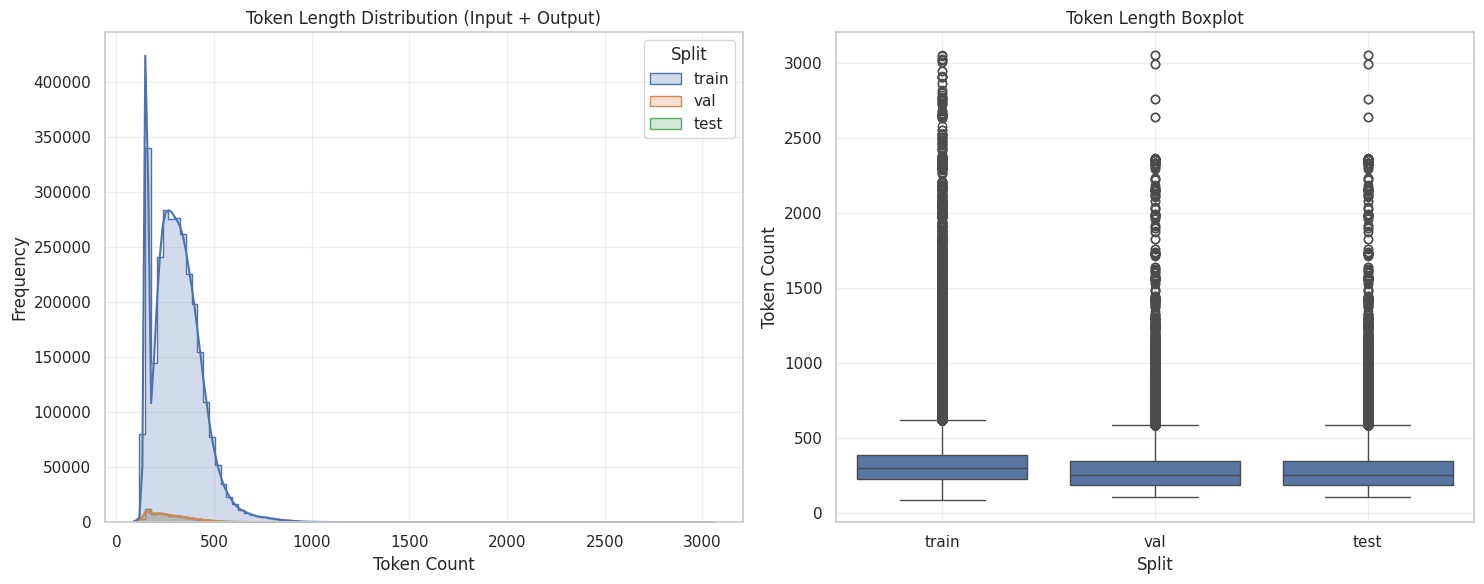

In [6]:
import datasets
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_from_disk
from transformers import AutoTokenizer
import os
import numpy as np

# =============================================================================
# [설정] 데이터셋 경로 및 모델 정보
# =============================================================================
# 사용자의 데이터셋 경로
TRAIN_PATH = "/home/jovyan/CHJ/Mol-LLM_Custom/dataset/llada_train/GSAI-ML-LLaDA-8B-Instruct_string+graph_q32_train_3.3M_0415"
VAL_PATH = "/home/jovyan/CHJ/Mol-LLM_Custom/dataset/llada_train/GSAI-ML-LLaDA-8B-Instruct_string+graph_q32_validation_3.3M_0415"
TEST_PATH = "/home/jovyan/CHJ/Mol-LLM_Custom/dataset/llada_train/GSAI-ML-LLaDA-8B-Instruct_string+graph_q32_test_3.3M_0415"

# 토크나이저 모델 ID (LLaDA-8B)
MODEL_ID = "GSAI-ML/LLaDA-8B-Instruct"

# 병렬 처리 프로세스 수 (CPU 코어 수에 맞춰 조절)
NUM_PROC = 32

def main():
    # 1. 토크나이저 로드
    print(f"Loading tokenizer: {MODEL_ID}")
    try:
        tokenizer = AutoTokenizer.from_pretrained(MODEL_ID, trust_remote_code=True)
        # Pad token이 없으면 EOS token으로 설정 (길이 측정에는 영향 없음)
        if tokenizer.pad_token is None:
            tokenizer.pad_token = tokenizer.eos_token
    except Exception as e:
        print(f"Error loading tokenizer: {e}")
        return

    # 2. 데이터셋 로드
    print("Loading datasets...")
    datasets_dict = {}
    try:
        if os.path.exists(TRAIN_PATH):
            datasets_dict['train'] = load_from_disk(TRAIN_PATH)
        if os.path.exists(VAL_PATH):
            datasets_dict['val'] = load_from_disk(VAL_PATH)
        if os.path.exists(TEST_PATH):
            datasets_dict['test'] = load_from_disk(TEST_PATH)
            
        if not datasets_dict:
            print("No datasets found at the specified paths.")
            return
            
        print(f"Loaded: {list(datasets_dict.keys())}")
        
    except Exception as e:
        print(f"Error loading datasets: {e}")
        return

    # 3. 토큰 길이 계산 함수
    def compute_length(batch):
        # prompt_text와 target_text가 컬럼에 있다고 가정합니다.
        # download_dataset_InstructGraph.py에서 'prompt_text', 'target_text'로 저장했습니다.
        
        # 전체 텍스트 = 프롬프트 + 정답 (학습 시 입력되는 전체 시퀀스)
        # LLaDA 등의 모델은 프롬프트와 타겟이 이어지도록 구성됩니다.
        full_texts = [p + t for p, t in zip(batch['prompt_text'], batch['target_text'])]
        
        # 토크나이징 (truncation=False로 전체 길이 측정)
        # encode_plus를 사용하여 정확한 토큰 ID 개수를 셉니다.
        encodings = tokenizer(full_texts, add_special_tokens=True, truncation=False)
        lengths = [len(ids) for ids in encodings['input_ids']]
        
        return {"total_length": lengths}

    # 4. 각 데이터셋 별 길이 계산 (병렬 처리)
    all_lengths = {}
    
    # 결과를 저장할 데이터프레임 리스트
    stats_list = []

    for split_name, ds in datasets_dict.items():
        print(f"\nProcessing {split_name} dataset ({len(ds)} examples)...")
        
        # map 함수로 병렬 처리
        ds_with_len = ds.map(
            compute_length,
            batched=True,
            num_proc=NUM_PROC,
            desc=f"Tokenizing {split_name}",
            # remove_columns=ds.column_names # 메모리 절약을 위해 기존 컬럼 제거 (길이만 남김) - 필요시 주석 해제
        )
        
        lengths = ds_with_len['total_length']
        all_lengths[split_name] = lengths
        
        # 통계 계산
        lengths_np = np.array(lengths)
        stats = {
            'Split': split_name,
            'Count': len(lengths),
            'Mean': np.mean(lengths_np),
            'Median': np.median(lengths_np),
            'Min': np.min(lengths_np),
            'Max': np.max(lengths_np),
            'Std': np.std(lengths_np),
            'P95': np.percentile(lengths_np, 95),
            'P99': np.percentile(lengths_np, 99)
        }
        stats_list.append(stats)
        
        print(f"--- {split_name.upper()} Statistics ---")
        for k, v in stats.items():
            if k != 'Split':
                print(f"{k}: {v:.2f}")

    # 5. 통계 표 생성 및 출력
    stats_df = pd.DataFrame(stats_list)
    print("\n" + "="*40)
    print(" [ Token Length Statistics Table ]")
    print("="*40)
    print(stats_df.to_string(index=False, float_format="%.2f"))
    print("="*40)

    # 6. 통합 시각화 (Histogram & Boxplot)
    print("\nGenerating visualization...")
    
    # 시각화용 데이터프레임 변환
    df_list = []
    for split, lengths in all_lengths.items():
        temp_df = pd.DataFrame({'Length': lengths, 'Split': split})
        df_list.append(temp_df)
    
    final_df = pd.concat(df_list, ignore_index=True)
    
    # 그래프 그리기
    plt.figure(figsize=(15, 6))
    
    # 6-1. 히스토그램 (Distribution)
    plt.subplot(1, 2, 1)
    sns.histplot(data=final_df, x='Length', hue='Split', bins=100, kde=True, element="step")
    plt.title("Token Length Distribution (Input + Output)")
    plt.xlabel("Token Count")
    plt.ylabel("Frequency")
    plt.grid(True, alpha=0.3)
    
    # 6-2. 박스플롯 (Outlier 확인용)
    plt.subplot(1, 2, 2)
    sns.boxplot(data=final_df, x='Split', y='Length')
    plt.title("Token Length Boxplot")
    plt.ylabel("Token Count")
    plt.grid(True, alpha=0.3)
    
    # 이미지 저장
    save_path = "token_length_analysis_llada.png"
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    print(f"\nVisualization saved to: {os.path.abspath(save_path)}")
    
    # 7. 추가 분석: 특정 길이 초과 비율 확인 (예: 256, 512, 1024, 2048)
    thresholds = [256, 512, 1024, 2048, 4096]
    print("\n[ Over-length Analysis ]")
    for split, lengths in all_lengths.items():
        total = len(lengths)
        print(f"\nDataset: {split}")
        for th in thresholds:
            count = sum(1 for l in lengths if l > th)
            ratio = (count / total) * 100
            print(f" > {th} tokens: {count} ({ratio:.2f}%)")

if __name__ == "__main__":
    # 멀티프로세싱 시작 방식 설정 (필요 시)
    # multiprocessing.set_start_method('spawn') 
    main()

# Token Count distribution per Task Group

Loading tokenizer: GSAI-ML/LLaDA-8B-Instruct

Processing Train dataset (2850760 examples)...

Processing Val dataset (70906 examples)...

Processing Test dataset (70906 examples)...

Generating Histogram Plots with Independent Y-axes...


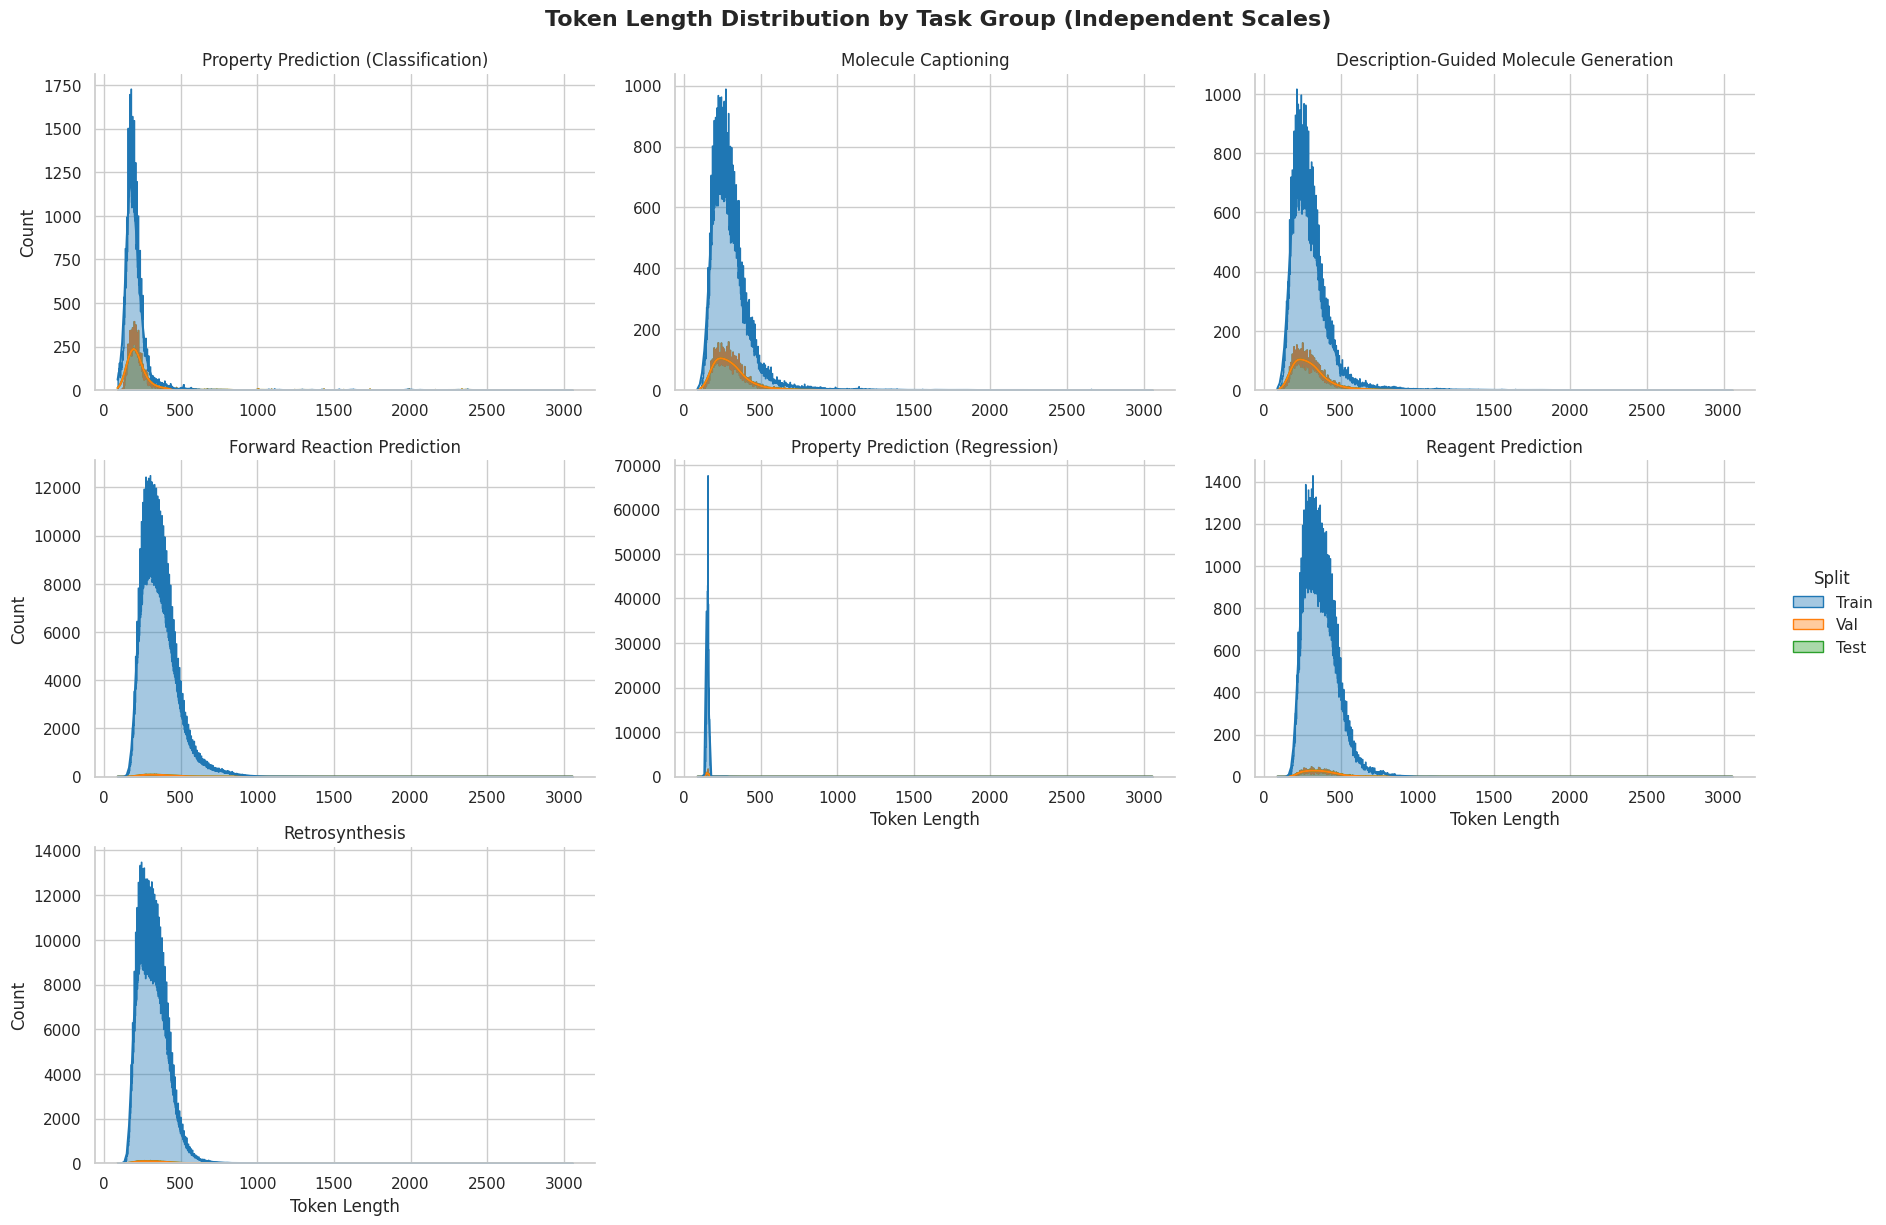

In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_from_disk
from transformers import AutoTokenizer

# =============================================================================
# [설정] 데이터셋 경로 및 모델 정보
# =============================================================================
TRAIN_PATH = "/home/jovyan/CHJ/Mol-LLM_Custom/dataset/llada_train/GSAI-ML-LLaDA-8B-Instruct_string+graph_q32_train_3.3M_0415"
VAL_PATH = "/home/jovyan/CHJ/Mol-LLM_Custom/dataset/llada_train/GSAI-ML-LLaDA-8B-Instruct_string+graph_q32_validation_3.3M_0415"
TEST_PATH = "/home/jovyan/CHJ/Mol-LLM_Custom/dataset/llada_train/GSAI-ML-LLaDA-8B-Instruct_string+graph_q32_test_3.3M_0415"

MODEL_ID = "GSAI-ML/LLaDA-8B-Instruct"
NUM_PROC = 32

# =============================================================================
# [Helper] Task Group Mapping Function
# =============================================================================
def get_task_group(task_name):
    if not isinstance(task_name, str): return "Others"
    t = task_name.lower()

    if "name_conversion" in t: return "Name Conversion"
    if "captioning" in t or "mol2text" in t: return "Molecule Captioning"
    if "generation" in t or "text2mol" in t: return "Description-Guided Molecule Generation"
    if "forward_reaction" in t or "forward_synthesis" in t: return "Forward Reaction Prediction"
    if "retrosynthesis" in t: return "Retrosynthesis"
    if "reagent" in t: return "Reagent Prediction"

    classification_keywords = ["tox21", "toxcast", "clintox", "bbbp", "bace", "sider", "hiv", "muv", "pcba", "multi_label_classification"]
    regression_keywords = ["esol", "freesolv", "lipo", "qm7", "qm8", "qm9", "u0", "cv", "mu", "alpha", "r2", "zpve", "gap", "homo", "lumo", "hopv"]

    for kw in classification_keywords:
        if kw in t: return "Property Prediction (Classification)"
    for kw in regression_keywords:
        if kw in t: return "Property Prediction (Regression)"
    
    if "classification" in t: return "Property Prediction (Classification)"
    if "regression" in t or "property" in t: return "Property Prediction (Regression)"

    return "Others"

def main():
    # 1. 토크나이저 로드
    print(f"Loading tokenizer: {MODEL_ID}")
    try:
        tokenizer = AutoTokenizer.from_pretrained(MODEL_ID, trust_remote_code=True)
        if tokenizer.pad_token is None:
            tokenizer.pad_token = tokenizer.eos_token
    except Exception as e:
        print(f"Error loading tokenizer: {e}")
        return

    # 2. 데이터셋 로드
    datasets_dict = {}
    if os.path.exists(TRAIN_PATH): datasets_dict['Train'] = load_from_disk(TRAIN_PATH)
    if os.path.exists(VAL_PATH): datasets_dict['Val'] = load_from_disk(VAL_PATH)
    if os.path.exists(TEST_PATH): datasets_dict['Test'] = load_from_disk(TEST_PATH)

    if not datasets_dict:
        print("No datasets found.")
        return

    # 3. 토큰 길이 계산 함수
    def compute_length(batch):
        full_texts = [p + t for p, t in zip(batch['prompt_text'], batch['target_text'])]
        encodings = tokenizer(full_texts, add_special_tokens=True, truncation=False)
        return {"total_length": [len(ids) for ids in encodings['input_ids']]}

    # 4. 데이터 처리
    all_data_list = []

    for split_name, ds in datasets_dict.items():
        print(f"\nProcessing {split_name} dataset ({len(ds)} examples)...")
        
        if 'task' not in ds.column_names:
            print(f"Warning: 'task' column missing in {split_name}.")
            continue

        ds_with_len = ds.map(
            compute_length,
            batched=True,
            num_proc=NUM_PROC,
            desc=f"Tokenizing {split_name}",
        )
        
        df_temp = ds_with_len.select_columns(['total_length', 'task']).to_pandas()
        df_temp['Split'] = split_name
        df_temp['Group'] = df_temp['task'].apply(get_task_group)
        
        all_data_list.append(df_temp)

    if not all_data_list:
        print("No data processed.")
        return

    full_df = pd.concat(all_data_list, ignore_index=True)

    # =============================================================================
    # 5. 시각화 (Seaborn FacetGrid Histogram) - Y축 독립 설정 적용
    # =============================================================================
    print("\nGenerating Histogram Plots with Independent Y-axes...")
    
    sns.set_theme(style="whitegrid")
    
    # [핵심 수정 사항] facet_kws={'sharey': False, 'sharex': False}
    # sharey=False: 각 서브플롯이 자신의 데이터 개수에 맞춰 Y축 높이를 따로 설정함
    # sharex=False: 토큰 길이 범위도 제각각일 수 있으므로 X축도 따로 설정함
    g = sns.displot(
        data=full_df,
        x="total_length",
        hue="Split",
        col="Group",
        col_wrap=3,
        kind="hist",
        kde=True,
        element="step",
        stat="count",
        common_norm=False,
        facet_kws={'sharey': False, 'sharex': False}, # 여기가 수정된 핵심입니다.
        height=4,
        aspect=1.5,
        palette={'Train': '#1f77b4', 'Val': '#ff7f0e', 'Test': '#2ca02c'},
        alpha=0.4
    )

    g.set_titles("{col_name}")
    g.set_axis_labels("Token Length", "Count")
    
    # 전체 제목 추가
    g.fig.suptitle("Token Length Distribution by Task Group (Independent Scales)", y=1.02, fontsize=16, fontweight='bold')

    # 이미지 저장
    # save_path = "token_length_histogram_independent.png"
    # plt.savefig(save_path, dpi=300, bbox_inches='tight')
    # print(f"Histogram saved to: {os.path.abspath(save_path)}")

if __name__ == "__main__":
    main()

=== Analyzing Impact of Threshold: 512 (with SELFIES Dictionary) ===
✅ Tokenizer loaded. Vocab size: 129325 (Includes SELFIES tokens)

Processing Train dataset (3450540 examples)...


Tokenizing Train (num_proc=64): 100%|██████████| 3450540/3450540 [00:27<00:00, 124761.54 examples/s]



Processing Val dataset (70906 examples)...


Tokenizing Val (num_proc=64): 100%|██████████| 70906/70906 [00:01<00:00, 61516.47 examples/s]



Processing Test dataset (70906 examples)...


Tokenizing Test (num_proc=64): 100%|██████████| 70906/70906 [00:01<00:00, 63957.86 examples/s] 



Calculating Threshold Impact Stats...

 [ Data Retention Analysis (Threshold = 512) ]
                                 Group Split  Total Count  Kept Count  Dropped Count  Retention Rate (%)
           Forward Reaction Prediction Train    1093705.0   1093473.0          232.0               100.0
                        Retrosynthesis Train    1067845.0   1067799.0           46.0               100.0
                       Name Conversion Train     599780.0    593065.0         6715.0                98.9
      Property Prediction (Regression) Train     357157.0    357157.0            0.0               100.0
                    Reagent Prediction Train     121896.0    121896.0            0.0               100.0
                   Molecule Captioning Train      75275.0     74637.0          638.0                99.2
Description-Guided Molecule Generation Train      75275.0     74635.0          640.0                99.1
  Property Prediction (Classification) Train      59607.0     59381.0    

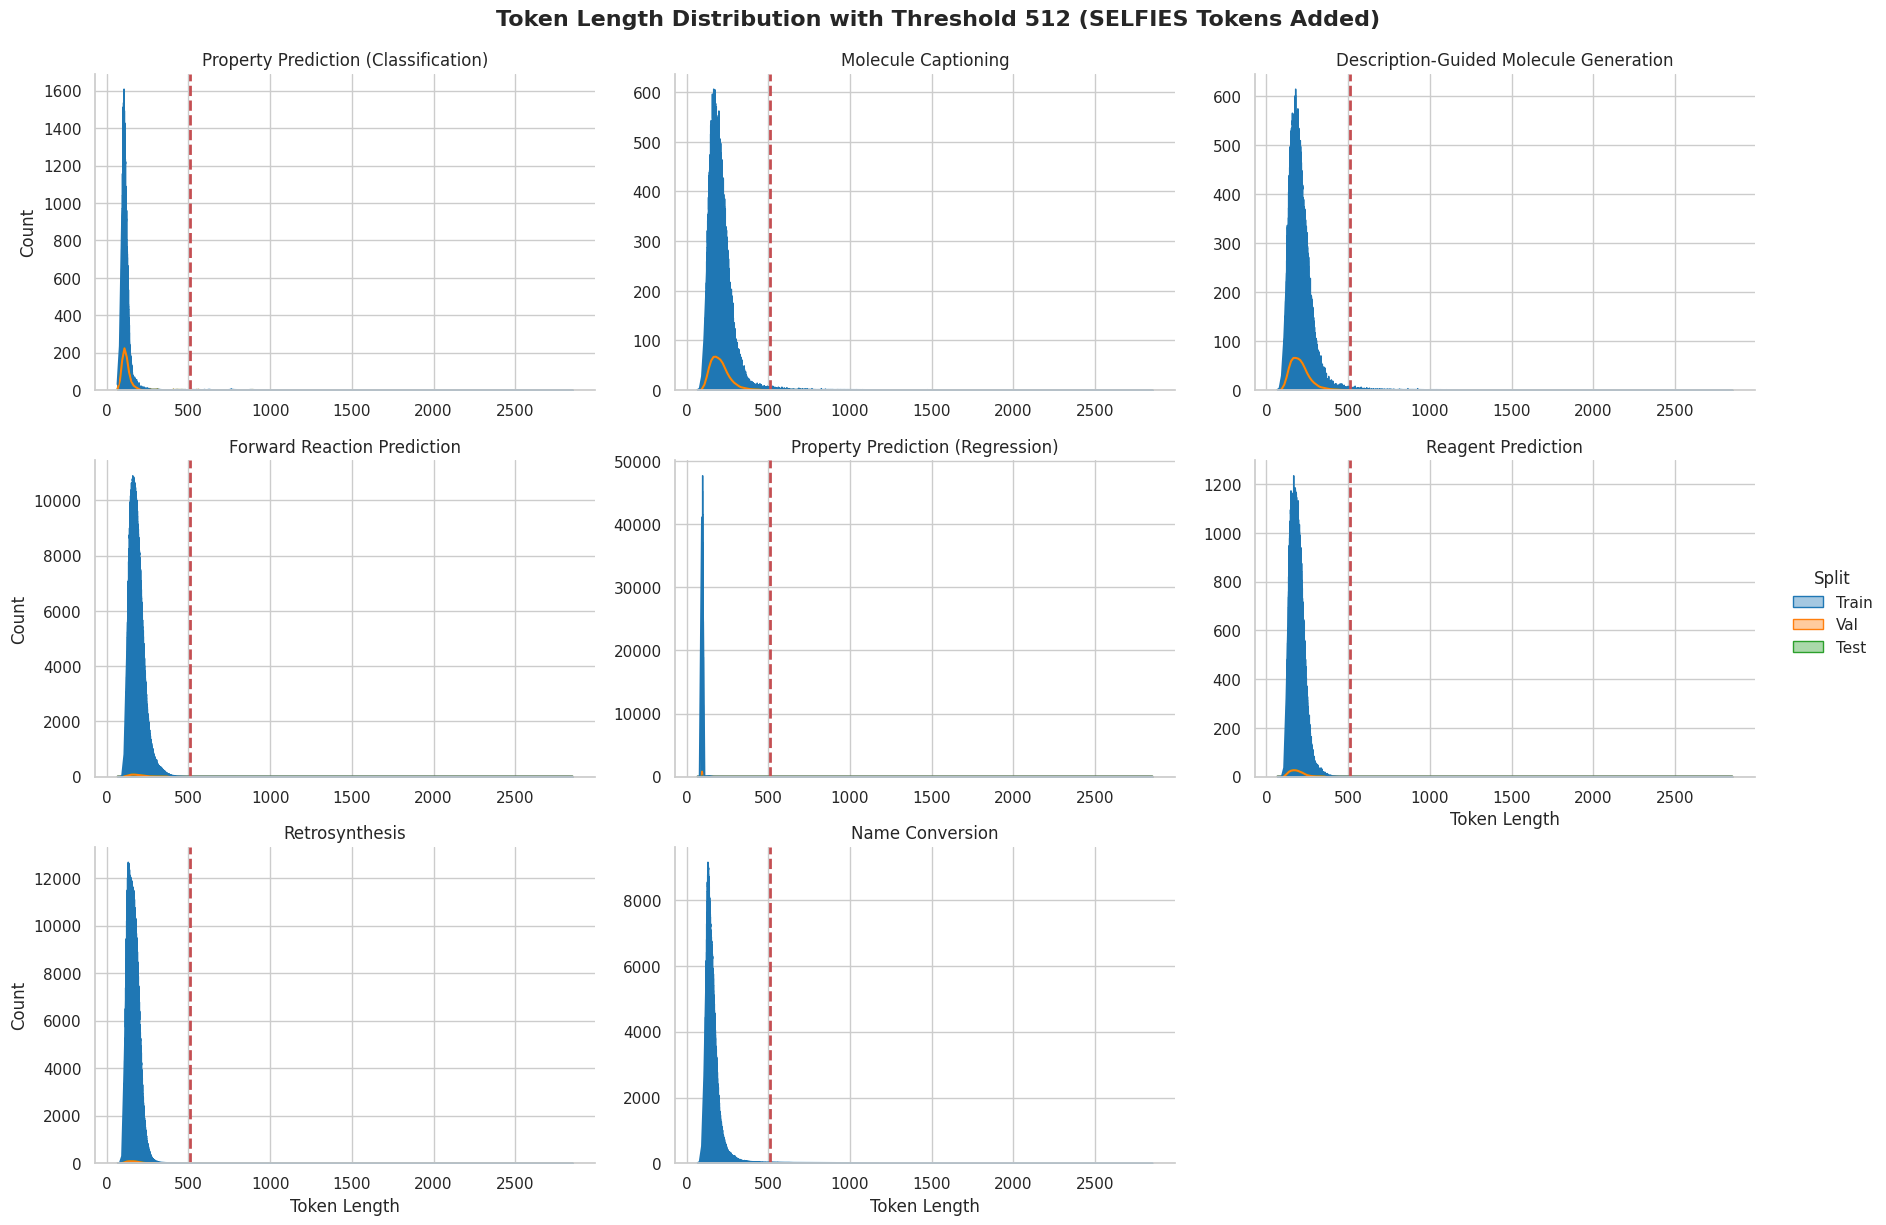

In [8]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_from_disk
from transformers import AutoTokenizer
import multiprocessing as mp

# =============================================================================
# [설정] 변수 입력
# =============================================================================
THRESHOLD = 512  # 분석할 길이 제한 기준
MODEL_ID = "GSAI-ML/LLaDA-8B-Instruct"
NUM_PROC = 64

# 데이터셋 경로
TRAIN_PATH = "/home/jovyan/CHJ/Mol-LLM_Custom/dataset/train/GSAI-ML-LLaDA-8B-Instruct_string+graph_q32_train_3.3M_0415_original"
VAL_PATH = "/home/jovyan/CHJ/Mol-LLM_Custom/dataset/train/GSAI-ML-LLaDA-8B-Instruct_string+graph_q32_validation_3.3M_0415_original"
TEST_PATH = "/home/jovyan/CHJ/Mol-LLM_Custom/dataset/train/GSAI-ML-LLaDA-8B-Instruct_string+graph_q32_test_3.3M_0415_original"

# SELFIES 사전 경로 (필터링 로직과 동일하게 적용)
SELFIES_DICT_PATH = "/home/jovyan/CHJ/Mol-LLM_Custom/model/selfies_dict.txt"

# 멀티프로세싱 설정
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# =============================================================================
# [1] Special Tokens 정의
# =============================================================================
BOOL = ["<BOOLEAN>", "</BOOLEAN>"]
FLOAT = ["<FLOAT>", "</FLOAT>"]
DESCRIPTION = ["<DESCRIPTION>", "</DESCRIPTION>"]
SELFIES = ["<SELFIES>", "</SELFIES>"]
MOL_2D = ["<GRAPH>", "</GRAPH>"]
MOL_3D = ["<3D_CONFORMER>", "</3D_CONFORMER>"]
MOL_EMBEDDING = ["<mol>"]
NUMBER = [f"<|{i}|>" for i in range(10)]
NUMBER.extend(["<|+|>", "<|-|>", "<|.|>"])
INSTRUCTION = ["<INSTRUCTION>", "</INSTRUCTION>"]
REACTION_DIRECTION = ["|>>|"]
IUPAC = ["<IUPAC>", "</IUPAC>"]
MOLFORMULA = ["<MOLFORMULA>", "</MOLFORMULA>"]

# 태그 목록
CUSTOM_SPECIAL_TOKENS = (
    BOOL + FLOAT + DESCRIPTION + SELFIES + MOL_2D + MOL_3D + 
    MOL_EMBEDDING + NUMBER + INSTRUCTION + REACTION_DIRECTION + 
    IUPAC + MOLFORMULA
)

# 전역 토크나이저 변수 (Worker 프로세스용)
global_tokenizer = None

def load_selfies_tokens(path):
    if not os.path.exists(path):
        print(f"[Warning] SELFIES dict not found at {path}")
        return []
    with open(path, 'r') as f:
        tokens = f.read().splitlines()
    return [t.strip() for t in tokens if t.strip()]

def init_worker():
    """
    각 워커 프로세스에서 토크나이저를 로드하고 
    모든 특수 토큰(태그 + SELFIES 사전)을 추가하여 길이를 정확히 계산합니다.
    """
    global global_tokenizer
    try:
        tokenizer = AutoTokenizer.from_pretrained(MODEL_ID, trust_remote_code=True)
        if tokenizer.pad_token is None:
            tokenizer.pad_token = tokenizer.eos_token
        
        # 1. Custom Tags 추가
        tokens_to_add = list(set(CUSTOM_SPECIAL_TOKENS))
        
        # 2. [핵심] SELFIES Dictionary 추가 (이 부분이 있어야 길이가 줄어듦)
        selfies_tokens = load_selfies_tokens(SELFIES_DICT_PATH)
        tokens_to_add.extend(selfies_tokens)
        
        # 3. 토크나이저에 추가 (중복 제거)
        existing_vocab = set(tokenizer.get_vocab().keys())
        final_tokens = [t for t in set(tokens_to_add) if t not in existing_vocab]
        
        if final_tokens:
            tokenizer.add_tokens(final_tokens)
            
        global_tokenizer = tokenizer
    except Exception as e:
        print(f"[Worker Error] Failed to load tokenizer: {e}")

# =============================================================================
# [Helper] Task Group Mapping Function
# =============================================================================
def get_task_group(task_name):
    if not isinstance(task_name, str): return "Others"
    t = task_name.lower()

    if "name_conversion" in t: return "Name Conversion"
    if "captioning" in t or "mol2text" in t: return "Molecule Captioning"
    if "generation" in t or "text2mol" in t: return "Description-Guided Molecule Generation"
    if "forward_reaction" in t or "forward_synthesis" in t: return "Forward Reaction Prediction"
    if "retrosynthesis" in t: return "Retrosynthesis"
    if "reagent" in t: return "Reagent Prediction"

    classification_keywords = ["tox21", "toxcast", "clintox", "bbbp", "bace", "sider", "hiv", "muv", "pcba", "multi_label_classification"]
    regression_keywords = ["esol", "freesolv", "lipo", "qm7", "qm8", "qm9", "u0", "cv", "mu", "alpha", "r2", "zpve", "gap", "homo", "lumo", "hopv"]

    for kw in classification_keywords:
        if kw in t: return "Property Prediction (Classification)"
    for kw in regression_keywords:
        if kw in t: return "Property Prediction (Regression)"
    
    if "classification" in t: return "Property Prediction (Classification)"
    if "regression" in t or "property" in t: return "Property Prediction (Regression)"

    return "Others"

# =============================================================================
# [Worker Function] Compute Length
# =============================================================================
def compute_length(batch):
    # 워커별 토크나이저 초기화 (최초 1회)
    if global_tokenizer is None:
        init_worker()
        
    full_texts = [p + t for p, t in zip(batch['prompt_text'], batch['target_text'])]
    # add_special_tokens=True를 해야 추가된 SELFIES 토큰들을 인식합니다.
    encodings = global_tokenizer(full_texts, add_special_tokens=True, truncation=False)
    return {"total_length": [len(ids) for ids in encodings['input_ids']]}

def main():
    print(f"=== Analyzing Impact of Threshold: {THRESHOLD} (with SELFIES Dictionary) ===")
    
    # 메인 프로세스에서 토크나이저 테스트
    init_worker()
    if global_tokenizer:
        print(f"✅ Tokenizer loaded. Vocab size: {len(global_tokenizer)} (Includes SELFIES tokens)")
    else:
        print("❌ Failed to load tokenizer.")
        return

    # 3. 데이터셋 로드
    datasets_dict = {}
    if os.path.exists(TRAIN_PATH): datasets_dict['Train'] = load_from_disk(TRAIN_PATH)
    if os.path.exists(VAL_PATH): datasets_dict['Val'] = load_from_disk(VAL_PATH)
    if os.path.exists(TEST_PATH): datasets_dict['Test'] = load_from_disk(TEST_PATH)

    if not datasets_dict:
        print("No datasets found.")
        return

    all_data_list = []
    for split_name, ds in datasets_dict.items():
        print(f"\nProcessing {split_name} dataset ({len(ds)} examples)...")
        if 'task' not in ds.column_names: continue

        # load_from_cache_file=False로 설정하여 이전의 잘못된 길이 계산 캐시를 무시
        ds_with_len = ds.map(
            compute_length,
            batched=True,
            num_proc=NUM_PROC,
            desc=f"Tokenizing {split_name}",
            load_from_cache_file=False
        )
        
        df_temp = ds_with_len.select_columns(['total_length', 'task']).to_pandas()
        df_temp['Split'] = split_name
        df_temp['Group'] = df_temp['task'].apply(get_task_group)
        all_data_list.append(df_temp)

    if not all_data_list: return
    full_df = pd.concat(all_data_list, ignore_index=True)

    # =============================================================================
    # 5. Threshold 영향 분석 (통계 표 출력)
    # =============================================================================
    print("\nCalculating Threshold Impact Stats...")

    def calculate_impact(x):
        total = len(x)
        kept = (x['total_length'] <= THRESHOLD).sum()
        dropped = total - kept
        retention_rate = (kept / total) * 100 if total > 0 else 0
        
        return pd.Series({
            'Total Count': total,
            'Kept Count': kept,
            'Dropped Count': dropped,
            'Retention Rate (%)': retention_rate
        })

    # GroupBy Apply 경고 방지를 위해 include_groups=False (Pandas 버전에 따라 다름, 여기선 reset_index 활용)
    try:
        impact_df = full_df.groupby(['Group', 'Split']).apply(calculate_impact, include_groups=False).reset_index()
    except TypeError:
        impact_df = full_df.groupby(['Group', 'Split']).apply(calculate_impact).reset_index()
        
    impact_df = impact_df.sort_values(by='Total Count', ascending=False)

    print("\n" + "="*100)
    print(f" [ Data Retention Analysis (Threshold = {THRESHOLD}) ]")
    print("="*100)
    
    pd.set_option('display.max_rows', None)
    pd.set_option('display.width', 1000)
    pd.set_option('display.float_format', '{:.1f}'.format)
    
    print(impact_df.to_string(index=False))
    print("="*100)
    
    total_all = impact_df['Total Count'].sum()
    kept_all = impact_df['Kept Count'].sum()
    dropped_all = total_all - kept_all
    print(f"Grand Total: {int(total_all):,} examples")
    print(f"Total Kept:  {int(kept_all):,} examples ({kept_all/total_all*100:.2f}%)")
    print(f"Total Dropped: {int(dropped_all):,} examples")
    print("="*100)

    # =============================================================================
    # 6. 시각화 (Threshold 라인 포함)
    # =============================================================================
    print("\nGenerating Visualization with Threshold Line...")
    
    sns.set_theme(style="whitegrid")
    
    g = sns.displot(
        data=full_df,
        x="total_length",
        hue="Split",
        col="Group",
        col_wrap=3,
        kind="hist",
        kde=True,
        element="step",
        stat="count",
        common_norm=False,
        facet_kws={'sharey': False, 'sharex': False},
        height=4,
        aspect=1.5,
        palette={'Train': '#1f77b4', 'Val': '#ff7f0e', 'Test': '#2ca02c'},
        alpha=0.4
    )

    for ax in g.axes.flat:
        ax.axvline(x=THRESHOLD, color='r', linestyle='--', linewidth=2, label=f'Threshold ({THRESHOLD})')

    g.set_titles("{col_name}")
    g.set_axis_labels("Token Length", "Count")
    g.fig.suptitle(f"Token Length Distribution with Threshold {THRESHOLD} (SELFIES Tokens Added)", y=1.02, fontsize=16, fontweight='bold')

    # save_path = f"token_length_threshold_{THRESHOLD}_analysis_v2.png"
    # plt.savefig(save_path, dpi=300, bbox_inches='tight')
    # print(f"Analysis plot saved to: {os.path.abspath(save_path)}")

if __name__ == "__main__":
    # Multiprocessing 시작 방식 설정 (호환성 위해)
    try:
        mp.set_start_method('spawn', force=True)
    except RuntimeError:
        pass
        
    main()

# 각 Task Group 별로 샘플 20개씩 추출해 샘플링 및 디코딩 출력 로직

In [2]:
import os
import pandas as pd
import numpy as np
import random
from datasets import load_from_disk
from transformers import AutoTokenizer

# =============================================================================
# [설정] 변수 입력
# =============================================================================
MODEL_ID = "GSAI-ML/LLaDA-8B-Instruct"
# 분석할 데이터셋 경로 (Train 등)
TARGET_PATHS = [
    "/home/jovyan/CHJ/Mol-LLM_Custom/dataset/train/GSAI-ML-LLaDA-8B-Instruct_string+graph_q32_train_3.3M_0415"
]
SAMPLES_PER_GROUP = 2
SELFIES_DICT_PATH = "/home/jovyan/CHJ/Mol-LLM_Custom/model/selfies_dict.txt"

# =============================================================================
# [1] Special Tokens 정의
# =============================================================================
# 1-1. Mol-LLM Custom Tokens
BOOL = ["<BOOLEAN>", "</BOOLEAN>"]
FLOAT = ["<FLOAT>", "</FLOAT>"]
DESCRIPTION = ["<DESCRIPTION>", "</DESCRIPTION>"]
SELFIES_TAGS = ["<SELFIES>", "</SELFIES>"]
MOL_2D = ["<GRAPH>", "</GRAPH>"]
MOL_3D = ["<3D_CONFORMER>", "</3D_CONFORMER>"]
MOL_EMBEDDING = ["<mol>"]
NUMBER = [f"<|{i}|>" for i in range(10)] + ["<|+|>", "<|-|>", "<|.|>"]
INSTRUCTION = ["<INSTRUCTION>", "</INSTRUCTION>"]
REACTION_DIRECTION = ["|>>|"]
IUPAC = ["<IUPAC>", "</IUPAC>"]
MOLFORMULA = ["<MOLFORMULA>", "</MOLFORMULA>"]

CUSTOM_SPECIAL_TOKENS = (
    BOOL + FLOAT + DESCRIPTION + SELFIES_TAGS + MOL_2D + MOL_3D + 
    MOL_EMBEDDING + NUMBER + INSTRUCTION + REACTION_DIRECTION + 
    IUPAC + MOLFORMULA
)

# 1-2. LLaDA / Llama-3 Special Tokens (명시적 확인용)
# 이미 모델에 포함되어 있지만, 텍스트 내에서 인식되도록 추가 리스트업
LLADA_SPECIAL_TOKENS = [
    "<|begin_of_text|>", "<|end_of_text|>", 
    "<|start_header_id|>", "<|end_header_id|>", "<|eot_id|>",
    "<|reserved_special_token_0|>", "<|reserved_special_token_1|>" 
]

def load_selfies_tokens(path):
    """selfies_dict.txt 파일에서 분자 토큰들을 읽어옵니다."""
    if not os.path.exists(path):
        print(f"[Warning] SELFIES dict not found at {path}. Tokens like [C] might be split.")
        return []
    
    with open(path, 'r') as f:
        tokens = f.read().splitlines()
    # 공백 제거 및 유효성 확인
    tokens = [t.strip() for t in tokens if t.strip()]
    return tokens

# =============================================================================
# [Helper] Task Group Mapping
# =============================================================================
def get_task_group(task_name):
    if not isinstance(task_name, str): return "Others"
    t = task_name.lower()
    if "name_conversion" in t: return "Name Conversion"
    if "captioning" in t or "mol2text" in t: return "Molecule Captioning"
    if "generation" in t or "text2mol" in t: return "Description-Guided Molecule Generation"
    if "forward_reaction" in t or "forward_synthesis" in t: return "Forward Reaction Prediction"
    if "retrosynthesis" in t: return "Retrosynthesis"
    if "reagent" in t: return "Reagent Prediction"
    if any(k in t for k in ["tox", "clintox", "bbbp", "bace", "sider", "hiv", "muv", "pcba", "classification"]): return "Property Prediction (Classification)"
    if any(k in t for k in ["esol", "lipo", "qm", "u0", "cv", "mu", "alpha", "r2", "zpve", "gap", "homo", "lumo", "hopv", "regression"]): return "Property Prediction (Regression)"
    return "Others"

def main():
    print(f"Loading tokenizer: {MODEL_ID}")
    try:
        tokenizer = AutoTokenizer.from_pretrained(MODEL_ID, trust_remote_code=True)
        if tokenizer.pad_token is None:
            tokenizer.pad_token = tokenizer.eos_token
        
        # -----------------------------------------------------------
        # [핵심] 토큰 추가 로직
        # -----------------------------------------------------------
        new_tokens = []
        
        # 1. Custom Tags (<SELFIES> 등)
        new_tokens.extend(CUSTOM_SPECIAL_TOKENS)
        
        # 2. SELFIES Vocabulary ([C], [Branch1] 등)
        selfies_tokens = load_selfies_tokens(SELFIES_DICT_PATH)
        print(f"Loaded {len(selfies_tokens)} SELFIES tokens from file.")
        new_tokens.extend(selfies_tokens)
        
        # 3. 중복 제거 후 토크나이저에 추가
        # 이미 있는 토큰은 제외하고 추가 (set 활용)
        existing_vocab = set(tokenizer.get_vocab().keys())
        tokens_to_add = [t for t in set(new_tokens) if t not in existing_vocab]
        
        num_added = tokenizer.add_tokens(tokens_to_add)
        print(f"✅ Added {num_added} new tokens to tokenizer.")
        
        # LLaDA Special Token들이 일반 텍스트로 인식되지 않도록 주의
        # (tokenizer.encode 시 special_tokens=True로 처리하거나 add_special_tokens 사용)
        # 여기서는 시각화를 위해 add_tokens로 '단어'로서 인식하게 만듭니다.
        
    except Exception as e:
        print(f"Error loading tokenizer: {e}")
        return

    # 데이터셋 로드
    loaded_datasets = []
    for path in TARGET_PATHS:
        if os.path.exists(path):
            print(f"Loading dataset from: {path}")
            loaded_datasets.append(load_from_disk(path))
    
    if not loaded_datasets:
        print("No datasets found.")
        return

    from datasets import concatenate_datasets
    full_dataset = concatenate_datasets(loaded_datasets)
    print(f"Total samples: {len(full_dataset)}")

    # =============================================================================
    # [Inspection] 그룹별 샘플링 및 토큰화 확인
    # =============================================================================
    task_groups = {}
    print("Grouping tasks...")
    all_tasks = full_dataset['task']
    for idx, task_name in enumerate(all_tasks):
        group = get_task_group(task_name)
        if group not in task_groups: task_groups[group] = []
        task_groups[group].append(idx)

    print(f"\n{'='*80}")
    print(f" [ Tokenization Inspection (Sample Count: {SAMPLES_PER_GROUP}/group) ]")
    print(f"{'='*80}")

    for group, indices in task_groups.items():
        print(f"\n\n>>> Task Group: {group} (Total items: {len(indices)})")
        
        sample_indices = random.sample(indices, min(len(indices), SAMPLES_PER_GROUP))
        
        for i, idx in enumerate(sample_indices):
            item = full_dataset[idx]
            full_text = item['prompt_text'] + item['target_text']
            
            # [수정] encode 시 add_special_tokens=False로 하되, 
            # 텍스트 내의 <|begin_of_text|> 등이 쪼개지지 않게 하려면 
            # 이들이 tokenizer.vocab에 있거나 added_tokens에 있어야 합니다.
            # Llama-3 tokenizer는 기본적으로 이를 인식하지만, encode 함수 옵션에 따라 다릅니다.
            
            token_ids = tokenizer.encode(full_text, add_special_tokens=True)
            tokens = tokenizer.convert_ids_to_tokens(token_ids)

            print(f"\n--- [Sample {i+1}] Task: {item['task']} (Length: {len(token_ids)}) ---")
            
            # 보기 좋게 Raw String 앞부분 출력
            display_text = full_text.replace("\n", "\\n")
            print(f"[Raw String]: {display_text} ...")
            
            # 토큰 분해 출력 (가독성을 위해 | 로 구분)
            # convert_ids_to_tokens 결과인 Ġ 등은 그대로 둡니다.
            token_view = " | ".join(tokens)
            print(f"[Tokenized View]:\n{token_view}")
            
            # 주요 태그가 깨졌는지 검사 (간단한 체크)
            if "< | SEL | F | IES >" in token_view.replace(" ", ""):
                print("⚠️ WARNING: <SELFIES> tag is split!")
            if "[ | C | ]" in token_view.replace(" ", ""):
                 print("⚠️ WARNING: SELFIES content [C] is split!")

    print("\nDone.")

if __name__ == "__main__":
    main()

Loading tokenizer: GSAI-ML/LLaDA-8B-Instruct
Loaded 2944 SELFIES tokens from file.
✅ Added 2976 new tokens to tokenizer.
Loading dataset from: /home/jovyan/CHJ/Mol-LLM_Custom/dataset/train/GSAI-ML-LLaDA-8B-Instruct_string+graph_q32_train_3.3M_0415
Total samples: 3450540
Grouping tasks...

 [ Tokenization Inspection (Sample Count: 2/group) ]


>>> Task Group: Property Prediction (Classification) (Total items: 59607)

--- [Sample 1] Task: smol-property_prediction-sider (Length: 116) ---
[Raw String]: <|startoftext|><|start_header_id|>system<|end_header_id|>\n\nYou are a helpful assistant for molecular chemistry, to address tasks including molecular property classification, molecular property regression, chemical reaction prediction, molecule captioning, molecule generation.<|eot_id|><|start_header_id|>user<|end_header_id|>\n\nAre there any known side effects of <SELFIES> [C][N][C][=Branch1][C][=O][C][=C][Branch1][=Branch1][N][=C][N][Ring1][Branch1][N][Branch1][C][C][C][Ring1][O][=O].[C][

# Export Vocab

In [8]:
import json
import os
from transformers import AutoTokenizer

# 1. 모델 경로 또는 ID 설정
MODEL_ID = "GSAI-ML/LLaDA-8B-Instruct" 

def main():
    print(f"Loading tokenizer from: {MODEL_ID}")
    try:
        tokenizer = AutoTokenizer.from_pretrained(MODEL_ID, trust_remote_code=True)
    except Exception as e:
        print(f"Error loading tokenizer: {e}")
        return

    # -------------------------------------------------------------------------
    # 1. 전체 Vocabulary 추출 (ID 순서대로 정렬)
    # -------------------------------------------------------------------------
    vocab = tokenizer.get_vocab()
    
    # ID를 기준으로 정렬 (0번부터 128xxx번까지)
    sorted_vocab = dict(sorted(vocab.items(), key=lambda item: item[1]))
    
    # JSON 저장
    vocab_filename = "llada_full_vocab.json"
    with open(vocab_filename, "w", encoding="utf-8") as f:
        json.dump(sorted_vocab, f, ensure_ascii=False, indent=2)
    
    print(f"\n✅ Full Vocabulary saved to: {os.path.abspath(vocab_filename)}")
    print(f"   - Total Vocab Size: {len(vocab)}")

    # -------------------------------------------------------------------------
    # 2. Special Tokens (Added Tokens) 추출
    # -------------------------------------------------------------------------
    # Llama-3 계열은 added_tokens_decoder에 특수 토큰 정보가 있습니다.
    special_tokens_map = {}
    
    # added_tokens_decoder 확인
    if hasattr(tokenizer, "added_tokens_decoder"):
        for token_id, token_obj in tokenizer.added_tokens_decoder.items():
            # token_obj는 AddedToken 객체일 수 있으므로 content만 추출
            content = token_obj.content if hasattr(token_obj, "content") else str(token_obj)
            special_tokens_map[token_id] = content
    
    # all_special_tokens 속성에서도 확인 (중복 제거)
    for token in tokenizer.all_special_tokens:
        token_id = tokenizer.convert_tokens_to_ids(token)
        if token_id not in special_tokens_map:
            special_tokens_map[token_id] = token

    # ID 순 정렬
    sorted_special = dict(sorted(special_tokens_map.items(), key=lambda item: int(item[0])))

    # JSON 저장
    special_filename = "llada_special_tokens.json"
    with open(special_filename, "w", encoding="utf-8") as f:
        json.dump(sorted_special, f, ensure_ascii=False, indent=2)

    print(f"✅ Special Tokens saved to: {os.path.abspath(special_filename)}")
    print(f"   - Special Tokens Count: {len(sorted_special)}")

    # -------------------------------------------------------------------------
    # [미리보기] 터미널에 일부 출력
    # -------------------------------------------------------------------------
    print("\n[Preview: Special Tokens]")
    for tid, token in list(sorted_special.items())[:10]: # 상위 10개만 출력
        print(f"  ID {tid}: {token}")
    print("  ...")

if __name__ == "__main__":
    main()

Loading tokenizer from: GSAI-ML/LLaDA-8B-Instruct

✅ Full Vocabulary saved to: /home/jovyan/CHJ/Mol-LLM_Custom/utils/llada_full_vocab.json
   - Total Vocab Size: 126349
✅ Special Tokens saved to: /home/jovyan/CHJ/Mol-LLM_Custom/utils/llada_special_tokens.json
   - Special Tokens Count: 269

[Preview: Special Tokens]
  ID 126080: <|startoftext|>
  ID 126081: <|endoftext|>
  ID 126082: [CLS]
  ID 126083: [gMASK]
  ID 126084: <|reserved_token_0|>
  ID 126085: <|reserved_token_1|>
  ID 126086: <|reserved_token_2|>
  ID 126087: <|reserved_token_3|>
  ID 126088: <|reserved_token_4|>
  ID 126089: <|reserved_token_5|>
  ...
